In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import statistics
#from function import *
import statsmodels.api as sm
from datetime import datetime, timedelta
import time
from btbase import *
from scipy.stats import norm

In [7]:
class train:
    
    # 初始化
    def __init__(self):
        self.dataframe = None
        self.data_laundry = None
        self.start_time = None
        self.end_time = None
        self.sigma_delta_price = None
    
    # 通过平台api获取数据
    def set_data(self, s_time, e_time, symbols='btc/usdt.spot.binance', fields=None, bar_type="1m", offset=None, engine_info=None):
        # 获取数据api
        self.dataframe = get_crypto_price(s_time, e_time, symbols=symbol_, fields=None, bar_type="1m", offset=None, engine_info=None)
        # 把收益率加入到dataframe中
        self.dataframe = self.dataframe.assign(return_close= self.dataframe['close'].pct_change() * 100)

        self.dataframe = self.dataframe.assign(delta_price = self.dataframe['close'] - self.dataframe['close'].shift(1)) 

        self.sigma_delta_price = np.std(self.dataframe['delta_price'])        
        # 获取数据的开始时间
        self.start_time = self.dataframe['e_date'].iloc[0]
        # 获取数据的结束时间
        self.end_time = self.dataframe['e_date'].iloc[-1]
    
    # 通过dataframe文件获取数据
    def set_data_df(self, dataframe):
        # 本地dataframe
        self.dataframe = dataframe.copy()
        
        # 把收益率加入到dataframe中 
        self.dataframe = self.dataframe.assign(return_close = self.dataframe['close'].pct_change() * 100) 

        self.dataframe = self.dataframe.assign(delta_price = self.dataframe['close'] - self.dataframe['close'].shift(1)) 

        self.sigma_delta_price = np.std(self.dataframe['delta_price'])
        # 获取数据的开始时间
        self.start_time = self.dataframe['e_date'].iloc[0] 
        # 获取数据的结束时间
        self.end_time = self.dataframe['e_date'].iloc[-1]
        
    
    # 方程用来得到相应步长的volatility
    def get_volatility(self, time_step):
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        # 建立dataframe
        hour_table = pd.DataFrame({'hour_e_time': time_range})
        # 根据time_step确定每个区间长度
        hour_table.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - time_step))
        volatility = []
        # 在dataframe中取出相应区间的收益率并计算标准差得到volatility
        for i in hour_table.index:
            volatility.append(np.std(self.dataframe['return_close'][(self.dataframe.e_date > hour_table.hour_s_time[i]) & (self.dataframe.e_date <=  hour_table.hour_e_time[i])].dropna()))
        # 加入dataframe
        hour_table['volatility'] = volatility
        # 换成顺序排列
        return hour_table.dropna()[::-1].reset_index(drop=True)
    
    # 相应步长内最高和最低值的差值
    def get_maximum_highlow_difference(self, time_step):
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        # 建立dataframe
        hour_table = pd.DataFrame({'hour_e_time': time_range})
        # 根据time_step确定每个区间长度
        hour_table.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - time_step))
        difference = []
        # 在dataframe中取出相应区间的最高和最低值做差
        for i in hour_table.index:
            df_curr = self.dataframe[(self.dataframe.e_date > hour_table.hour_s_time[i]) & (self.dataframe.e_date <=  hour_table.hour_e_time[i])]
            high = max(df_curr['high'].dropna())
            low = min(df_curr['low'].dropna())
            difference.append(high - low)
        # 加入dataframe
        hour_table['highlow_difference'] = difference
        # 换成顺序排列
        return hour_table.dropna()[::-1].reset_index(drop=True)      
    
    
    def get_highlow(self, time_step):
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        # 建立dataframe
        hour_table = pd.DataFrame({'hour_e_time': time_range})
        # 根据time_step确定每个区间长度
        hour_table.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - time_step))
        highlow = []
        # 在dataframe中取出相应区间的high和low的差值并计算标准差得到
        for i in hour_table.index:
            df_curr = self.dataframe[(self.dataframe.e_date > hour_table.hour_s_time[i]) & (self.dataframe.e_date <=  hour_table.hour_e_time[i])]
            highlow.append(np.sum(df_curr['high'] - df_curr['low']))
        # 加入dataframe
        hour_table['highlow'] = highlow
        # 换成顺序排列
        return hour_table.dropna()[::-1].reset_index(drop=True)  

    def get_volume_sum(self, time_step):
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        # 建立dataframe
        hour_table = pd.DataFrame({'hour_e_time': time_range})
        # 根据time_step确定每个区间长度
        hour_table.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - time_step))
        volume_sum = []
        # 在dataframe中取出相应区间的high和low的差值并计算标准差得到
        for i in hour_table.index:
            df_curr = self.dataframe[(self.dataframe.e_date > hour_table.hour_s_time[i]) & (self.dataframe.e_date <=  hour_table.hour_e_time[i])]
            volume_sum.append(np.sum(df_curr['volume']))
        # 加入dataframe
        hour_table['volume_sum'] = volume_sum
        # 换成顺序排列
        return hour_table.dropna()[::-1].reset_index(drop=True)  

    # VPIN( Volume-synchronized Probability of Informed Trading)
    # bucket_length: 每个区间的长度
    # bucket_num: 每个区间的个数
    def get_vpin(self, bucket_length, bucket_num):
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        # 建立dataframe
        hour_table = pd.DataFrame({'hour_e_time': time_range})
        # 根据time_step确定每个区间长度
        #hour_table.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - time_step))
        vpin_all = []

        # 在dataframe中取出相应区间的high和low的差值并计算标准差得到
        for i in hour_table.index:
            # 记录当前period的endtime用来计算volume具体到哪个时间
            current_date = hour_table.hour_e_time[i]
            vpin = 0
            # 计算vpin
            # 每个bucket的vpin
            for i in range(bucket_num):
                VB = 0
                VS = 0
                V = 0
                # loop直到达到bucket_length
                while V < bucket_length:
                    # 如果当前时间不在dataframe中则跳出
                    if current_date not in self.dataframe.e_date.values:
                        break
                    # 记录delta_p和volume
                    # 把每分钟当成一个trade
                    delta_p = self.dataframe['delta_price'][self.dataframe.e_date == current_date].values[0]
                    Vi = self.dataframe['volume'][self.dataframe.e_date == current_date].values[0]
                    # 计算Vbuy 和 Vsell 通过cdf
                    VB = VB + Vi* norm.cdf(delta_p/self.sigma_delta_price)
                    VS = VS + Vi * (1- norm.cdf(delta_p/self.sigma_delta_price))
                    V = V + Vi
                    # 时间向前一分钟（前一个trade）
                    current_date = current_date - timedelta(minutes = 1)
                # 如果当前时间不在dataframe中则跳出    
                if current_date not in self.dataframe.e_date.values:
                    break
                # 计算vpin
                vpin = vpin + (np.absolute(VB - VS))/V
            # 如果当前时间不在dataframe中则跳出    
            if current_date not in self.dataframe.e_date.values:
                vpin_all.append(np.nan)
            else:
                vpin_all.append(vpin/bucket_num)   
        # 加入dataframe
        hour_table['vpin'] = vpin_all
        # 换成顺序排列
        return hour_table.dropna()[::-1].reset_index(drop=True)    
        

    def get_trade_sum(self, time_step):
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        # 建立dataframe
        hour_table = pd.DataFrame({'hour_e_time': time_range})
        # 根据time_step确定每个区间长度
        hour_table.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - time_step))
        trades = []
        # 在dataframe中取出相应区间的high和low的差值并计算标准差得到
        for i in hour_table.index:
            df_curr = self.dataframe[(self.dataframe.e_date > hour_table.hour_s_time[i]) & (self.dataframe.e_date <=  hour_table.hour_e_time[i])]
            trades.append(np.sum(df_curr['trades'])) 
        # 加入dataframe
        hour_table['trades_sum'] = trades
        # 换成顺序排列
        return hour_table.dropna()[::-1].reset_index(drop=True)              


    # 计算每个区间头尾的收益率的平方
    def get_return_square(self, time_step):
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        # 建立dataframe
        hour_table = pd.DataFrame({'hour_e_time': time_range})
        # 根据time_step确定每个区间长度
        hour_table.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - time_step))
        return_square = []
        # 在dataframe中取出相应区间的high和low的差值并计算标准差得到
        for i in hour_table.index:
            close = self.dataframe['close'][(self.dataframe.e_date > hour_table.hour_s_time[i]) & (self.dataframe.e_date <=  hour_table.hour_e_time[i])].dropna()
            return_square.append(((close.values[0] - close.values[-1] )/ close.values[0])**2)
            #return_square.append((np.log(close.values[0]/close.values[-1]))**2)
        # 加入dataframe
        hour_table['return_square'] = return_square
        # 换成顺序排列
        return hour_table.dropna()[::-1].reset_index(drop=True)
    
    # 计算每个区间volume_sum的zscore
    def get_zscore(self, time_step, period):
        # 得到每个区间的volume_sum
        original = self.get_volume_sum(time_step)
        zscore = []

        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        # 建立dataframe
        hour_table = pd.DataFrame({'hour_e_time': time_range})
        # 根据period确定每个区间长度
        hour_table.insert(0, 'hour_s_period' , time_range + timedelta(hours = - period))  
        
        # 删除最后一个区间
        # 因为最后一个区间的数据是不完整的
        hour_table = hour_table.iloc[:-period]
        
        # 计算zscore
        for i in hour_table.index:
            # 取出相应区间的volume_sum
            df_curr = original[(original.hour_e_time > hour_table.hour_s_period[i]) & (original.hour_e_time <=  hour_table.hour_e_time[i])]
            zscore.append((df_curr['volume_sum'].iloc[-1] - np.mean(df_curr['volume_sum']))/np.std(df_curr['volume_sum']))
        
        # 加入dataframe
        hour_table['zscore'] = zscore
        
        # 换成顺序排列
        return hour_table.dropna()[::-1].reset_index(drop=True)    

    def HLVGARCH_MA(self, order = [1, 1, 1, 1, 1, 1], timestep = [60, 60, 60, [120,10], 60, 60], ma = 0):
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        # 建立dataframe
        self.data_laundry = pd.DataFrame({'hour_e_time': time_range})
        # 根据time_step确定每个区间长度
        self.data_laundry.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - 60))
        # 换成顺序排列
        self.data_laundry = self.data_laundry.dropna()[::-1].reset_index(drop=True)
        
        # 得到volatility
        dataframe_volatility_real = self.get_volatility(60).drop(columns = ['hour_s_time'])
        
        # 把真实的volatility加入到dataframe中
        self.data_laundry = self.data_laundry.merge(dataframe_volatility_real, on = 'hour_e_time', how = 'inner')

        if order[0] >0:
            # 得到每个时段的highlow_difference
            dataframe_highlow_diff = self.get_maximum_highlow_difference(timestep[0]).drop(columns = ['hour_s_time'])
            for i in range(order[0]):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的highlow_difference
                dataframe_highlow_diff['highlow_difference_t' + str(i)] = dataframe_highlow_diff['highlow_difference'].shift(i+1)  
            # 根据endtime合并 dataframe    
            self.data_laundry = self.data_laundry.merge(dataframe_highlow_diff.drop(columns = ['highlow_difference']), on = 'hour_e_time', how = 'inner')
        
        if order[1] >0:
            # 得到每个时段的highlow
            dataframe_highlow = self.get_highlow(timestep[1]).drop(columns = ['hour_s_time'])
            for i in range(order[1]):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的highlow
                dataframe_highlow['highlow_t' + str(i)] = dataframe_highlow['highlow'].shift(i+1)
            # 根据endtime合并 dataframe    
            self.data_laundry = self.data_laundry.merge(dataframe_highlow.drop(columns = ['highlow']), on = 'hour_e_time', how = 'inner')

        if order[2] >0:
            # 得到每个时段的volume_sum
            dataframe_volume_sum = self.get_volume_sum(timestep[2]).drop(columns = ['hour_s_time'])
            for i in range(order[2]):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的volume_sum
                dataframe_volume_sum['volume_sum_t' + str(i)] = dataframe_volume_sum['volume_sum'].shift(i+1)
            # 根据endtime合并 dataframe    
            self.data_laundry = self.data_laundry.merge(dataframe_volume_sum.drop(columns = ['volume_sum']), on = 'hour_e_time', how = 'inner')

        if order[3] >0:
            # 得到每个时段的return_square
            dataframe_vpin = self.get_vpin(timestep[3][0], timestep[3][1])
            for i in range(order[3]):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的return_square
                dataframe_vpin['vpin_t' + str(i)] = dataframe_vpin['vpin'].shift(i+1)
            # 根据endtime合并 dataframe    
            self.data_laundry = self.data_laundry.merge(dataframe_vpin.drop(columns = ['vpin']), on = 'hour_e_time', how = 'inner')

        if order[4] >0:
            # 得到每个时段的volatility
            dataframe_volatility = self.get_volatility(timestep[4]).drop(columns = ['hour_s_time'])
            for i in range(order[4]):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的volatility
                dataframe_volatility['volatility_t' + str(i)] = dataframe_volatility['volatility'].shift(i+1)
            # 根据endtime合并 dataframe    
            self.data_laundry = self.data_laundry.merge(dataframe_volatility.drop(columns = ['volatility']), on = 'hour_e_time', how = 'inner')

        if order[5] >0:
            # 得到每个时段的volatility
            dataframe_trades = self.get_trade_sum(timestep[5]).drop(columns = ['hour_s_time'])
            for i in range(order[5]):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的volatility
                dataframe_trades['trades_sum_t' + str(i)] = dataframe_trades['trades_sum'].shift(i+1)
            # 根据endtime合并 dataframe    
            self.data_laundry = self.data_laundry.merge(dataframe_trades.drop(columns = ['trades_sum']), on = 'hour_e_time', how = 'inner')   
        
        # 删除缺失值
        self.data_laundry = self.data_laundry.dropna()
       
        # 真实的volatility 用来拟合
        Y = self.data_laundry['volatility']
        # 除了volatility的其他数据 用来作为自变量
        X = self.data_laundry.drop(columns = ['hour_e_time', 'hour_s_time', 'volatility'])
        
        # 拟合模型
        model = sm.OLS(Y, sm.add_constant(X)).fit()
        
        # 预测volatility
        self.data_laundry['predict_volatility'] = model.predict(sm.add_constant(X))
    
        self.data_laundry['volatility'] = self.data_laundry['volatility']
        
        # 如果有moving average
        if ma > 0:
            # 计算误差
            self.data_laundry['error'] = self.data_laundry['volatility'] - self.data_laundry['predict_volatility']
            # 得到t-1, t-2, t-3。。。的误差
            for i in range(ma):
                self.data_laundry['error_t' + str(i)] = self.data_laundry['error'].shift(i+1)
            
            # 删除缺失值
            self.data_laundry = self.data_laundry.dropna()
            # 真实的volatility 用来拟合
            Y = self.data_laundry['volatility']
            # 除了volatility的其他数据 用来作为自变量
            X = self.data_laundry.drop(columns = ['hour_e_time', 'hour_s_time', 'volatility', 'predict_volatility', 'error'])
            # 拟合模型
            model = sm.OLS(Y, sm.add_constant(X)).fit()  
            self.data_laundry = self.data_laundry.drop(columns = ['error']) 

        
        # 加入真实volatility和预测volatility
        self.data_laundry['real'] = self.data_laundry['volatility']
        self.data_laundry['predict'] = model.predict(sm.add_constant(X))
        
        # 删除不需要的数据
        self.data_laundry = self.data_laundry.drop(columns = ['volatility', 'predict_volatility'])
        return model

In [8]:
symbol_ = 'btc/usdt.spot.binance'
# set the start time
s_time = datetime.datetime(2023, 1 ,1, 2, 0, 0)
# set the end time
e_time = datetime.datetime(2024, 1, 1, 1, 59, 0)

In [9]:
data = train()
data.set_data(s_time, e_time, symbols='btc/usdt.spot.binance', fields=None, bar_type="1m", offset=None, engine_info=None)

In [10]:
model = data.HLVGARCH_MA(order = [0, 1, 1, 1, 1, 0], timestep = [30, 60, 10, [120,10], 10, 60], ma = 0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             volatility   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     1524.
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        18:45:06   Log-Likelihood:                 19080.
No. Observations:                8759   AIC:                        -3.815e+04
Df Residuals:                    8754   BIC:                        -3.811e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0161      0.001     27.547      0.000       0.015       0.017
highlow_t0     1.482e-05   6.01e-07     24.658      0.000    1.36e-05     1.6e-05
volume_sum_t0  3.191e-06   3.41e-07      9.344      0.000    2.52e-06    3.86e-06
vpin_t0           0.0337      0.004      9.025      0.000       0.026       0.041
volatility_t0     0.1408      0.015      9.671      0.000       0.112       0.169
==============================================================================
Omnibus:                    11043.235   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3755902.409
Skew:                           6.622   Prob(JB):                         0.00
Kurtosis:                     103.578   Cond. No.                     8.24e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
data.data_laundry.corr()

,highlow_t0,volume_sum_t0,vpin_t0,volatility_t0,real,predict
highlow_t0,1.000000,0.484984,0.793340,0.719416,0.605371,0.944766
volume_sum_t0,0.484984,1.000000,0.608204,0.585168,0.433347,0.676297
vpin_t0,0.793340,0.608204,1.000000,0.769125,0.582303,0.908764
volatility_t0,0.719416,0.585168,0.769125,1.000000,0.551874,0.861276
real,0.605371,0.433347,0.582303,0.551874,1.000000,0.640763
predict,0.944766,0.676297,0.908764,0.861276,0.640763,1.000000


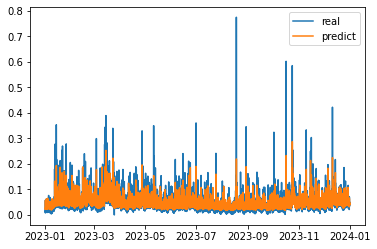

In [12]:
plt.plot(data.data_laundry['hour_e_time'], data.data_laundry['real'], label = 'real')
plt.plot(data.data_laundry['hour_e_time'], data.data_laundry['predict'], label = 'predict')
plt.legend()